### NOTES
* States, whether "delivery" or "billing" are a mix of full names and abbreviations, we don't use these as of right now, but if we choose to sometime then we must change abbreviations to full names or vice versa.

### REMINDER for the future
* Take into account the % fee for chargebacks, not just the order total

### Libraries

In [2]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

from osh_data import *

### Script settings

In [3]:
r_write = 'on'

In [4]:
date_end = '2019-01-31'

# this is for the predictive model
# the first month we started marking orders as "fraud - void" instead of deleting them
fraud_date_start = '2018-05-01' 

# this is for the giant data pull
# go back 1.5 years from date_end
d = str((pd.to_datetime(date_end) - pd.DateOffset(years = 1, months = 6)).date())[:7] + '-01'

# make the date_start the min date between fraud_date_start and the date 1.5 years ago
date_start = str(np.min([pd.to_datetime(fraud_date_start).date(), pd.to_datetime(d).date()]))

m = 3
three_months_ago = str((pd.to_datetime(date_end) - pd.DateOffset(months = (m-1))).date())[:7] + '-01'

csv_path = '/Users/jarad/Fake Folder/CSP/Recurring/Fraud and Chargeback Report/CSVs/'

### Chart settings

In [5]:
style_sheet_path = '/Users/jarad/Fake Folder/Matplotlib Stylesheets/the_pillars_stylesheet.mplstyle'
plt.style.use(style_sheet_path)

alpha = 0.8

adablue01 = '#00ffff'
adablue02 = '#00a6e9'
adapink = '#ff00ff'
adapurple = '#662d91'
adayellow = '#ffff00'
adagreen = '#00ff00'

colors = [adablue01,adablue02,adapink,adayellow,adapurple,adagreen] * 10

### Some info
From Kelly in email with subject line "CSP Monthly Chargeback/Fraud Report":
* Fraud stopped
* Fraud - Void (orders_status = 15)


* Fraud not stopped
* Fraud - Confirmed (orders_status = 9)

*****

* [CSP Shift Report Google Doc](https://docs.google.com/spreadsheets/d/1RfqZtU-qZY7_Xn1gAZ15LBS2nshO5RBwPLRDmfFTx4M/edit#gid=300944739), for reference, but numbers are different from db since the google doc is user-entered; we don't use it here in this script, we get the data straight from the db.

### Get data

In [6]:
osh_main = get_osh_data(fraud_date_start, date_end)


== osh_main start ==


== osh_main end ==



### All statuses

In [7]:
a = osh_main.groupby(['year and month added','orders status name'])[['order subtotal']].sum().unstack(1).fillna(0)
a.columns = a.columns.droplevel(0)

fmt = ['m0'] * len(a.columns)
a.format_(fmt)

,Billed,Fraud - Confirmed,Fraud - Pending,Fraud - Void,No Shipment Necessary,Pending,Printed,Processing,Return,Shipped,Voided
year and month added,,,,,,,,,,,
2018-05,$0,"$5,938",$0,"$14,005","$31,828",$0,$0,$270,"$22,896","$3,843,556","$118,662"
2018-06,$0,"$1,508",$0,"$16,146","$7,724","$16,511",$0,$50,"$17,751","$3,428,852","$54,592"
2018-07,$0,"$3,664",$0,"$8,747","$1,570","$400,000",$0,$170,"$33,599","$3,368,009","$62,569"
2018-08,$366,"$1,024",$0,"$15,524","$3,465",$0,$0,$350,"$33,196","$3,537,080","$57,495"
2018-09,"$1,423",$542,$0,"$16,993","$153,684","$30,965",$0,$166,"$17,987","$3,052,417","$66,984"
2018-10,$0,"$1,535",$0,"$20,463","$4,075","$84,635",$0,$200,"$30,163","$3,666,439","$106,605"
2018-11,$0,"$1,720",$0,"$8,969","$10,597","$18,256",$0,$120,"$13,834","$3,558,402","$192,064"
2018-12,$0,"$1,240",$0,"$3,482","$31,438","$289,750",$30,"$1,815","$18,792","$4,124,245","$61,531"
2019-01,$0,"$1,578","$1,312","$7,274","$54,168","$808,049","$138,145","$47,288","$16,973","$3,981,103","$50,431"


### Just fraud

In [8]:
ls = ['fraud - confirmed','fraud - void']

fraud_main = osh_main[(osh_main['orders status name'].isin(ls))
                    & (osh_main['date added'] >= fraud_date_start)].copy()
fraud_main.reset_index(drop = True, inplace = True)

### Get total revenue data

In [9]:
# recall that daily_stats uses the order subtotal
ds_main = pd.read_sql(
'''
SELECT
timestamp AS date,
d_value AS total_revenue
FROM daily_stats
WHERE d_class = 'd_all'
AND timestamp BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
''', db)

col_fix(ds_main)

ds_main['date'] = pd.to_datetime(ds_main['date'])
ds_main['year and month'] = jb_dates(ds_main['date'], 'year and month')

ds = ds_main.groupby('year and month')[['total revenue']].sum()

### Structure it

In [10]:
fraud = fraud_main.groupby(['year and month added','orders status name'])[['order subtotal']].sum().unstack(1).fillna(0)
fraud.columns = fraud.columns.droplevel(0)

fraud['total fraud'] = fraud.sum(1)
fraud['total revenue'] = fraud.index.to_series().map(dict(zip(ds.index.to_series(), ds['total revenue'])))
fraud['% of fraud stopped'] = fraud['fraud - void']/fraud['total fraud']
fraud['fraud as a % of total revenue'] = fraud['total fraud']/fraud['total revenue']

In [11]:
fmt = ['m0','m0','m0','m0','p1','p1']

display(jb_mean(fraud, fmt))
fraud.format_(fmt)

,mean
Fraud - Confirmed,"$2,083"
Fraud - Void,"$12,400"
Total Fraud,"$14,484"
Total Revenue,"$3,505,474"
% Of Fraud Stopped,84.0%
Fraud As A % Of Total Revenue,0.4%


,Fraud - Confirmed,Fraud - Void,Total Fraud,Total Revenue,% Of Fraud Stopped,Fraud As A % Of Total Revenue
year and month added,,,,,,
2018-05,"$5,938","$14,005","$19,943","$3,933,957",70.2%,0.5%
2018-06,"$1,508","$16,146","$17,654","$3,272,851",91.5%,0.5%
2018-07,"$3,664","$8,747","$12,411","$3,448,737",70.5%,0.4%
2018-08,"$1,024","$15,524","$16,548","$3,141,298",93.8%,0.5%
2018-09,$542,"$16,993","$17,534","$3,081,421",96.9%,0.6%
2018-10,"$1,535","$20,463","$21,998","$4,164,699",93.0%,0.5%
2018-11,"$1,720","$8,969","$10,689","$3,886,270",83.9%,0.3%
2018-12,"$1,240","$3,482","$4,722","$3,153,960",73.7%,0.1%
2019-01,"$1,578","$7,274","$8,852","$3,466,075",82.2%,0.3%


### Confidence intervals

In [230]:
fmt = ['m0','m0','m0','m0','p1','p1']
jb_conf(fraud).loc[:'upper'].format_(fmt).T

,lower,mean,upper
Fraud - Confirmed,$791,"$2,083","$3,375"
Fraud - Void,"$8,161","$12,400","$16,640"
Total Fraud,"$10,139","$14,484","$18,828"
Total Revenue,"$3,200,652","$3,505,474","$3,810,297"
% Of Fraud Stopped,75.9%,84.0%,92.0%
Fraud As A % Of Total Revenue,0.3%,0.4%,0.5%


### Plot it

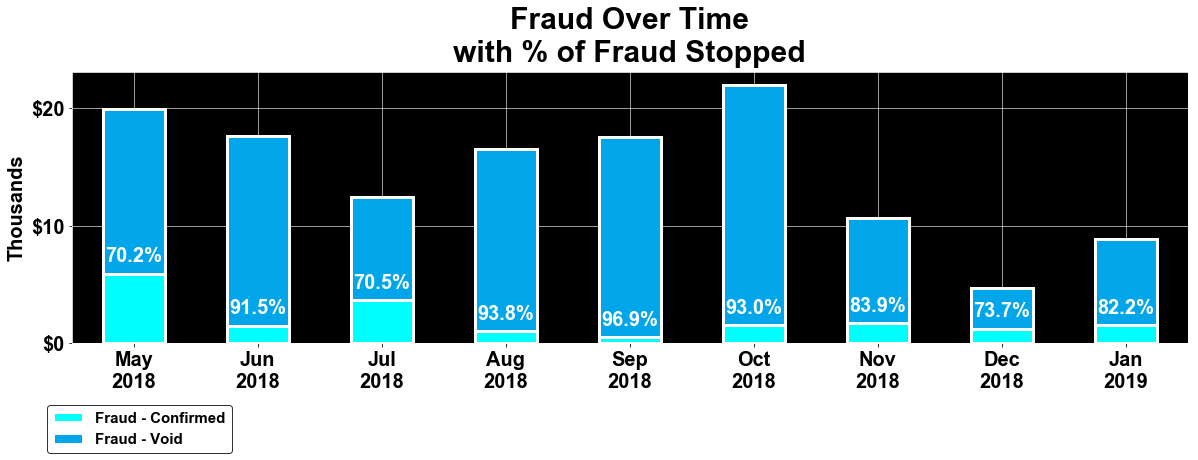

In [12]:
fig, ax = plt.subplots(figsize = (20,5))

cols = ['fraud - confirmed','fraud - void']

fraud[cols].plot(ax = ax,
                 kind = 'bar',
                 stacked = True,
                 edgecolor = 'white',
                 lw = 3,
                 color = colors,
                 zorder = 5)

ax.set_xticklabels(jb_dates(pd.Series(fraud.index), 'year and month xticks'), rotation = 0, fontsize = 20)
ax.set_yticklabels(['${:,.0f}'.format(x/1000) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Thousands', fontsize = 20)
ax.set_xlabel('')
ax.legend([x.title() for x in cols], bbox_to_anchor = (0.15,-0.20), edgecolor = 'black', fontsize = 15)
ax.set_title('Fraud Over Time\nwith % of Fraud Stopped', y = 1.02, fontsize = 30)
ax.grid(color = 'white', alpha = 0.75, zorder = 0)

for i in range(len(fraud)):
    x = i
    y = fraud.iloc[i]['fraud - confirmed'] + 1000
    wrt = fraud.iloc[i]['% of fraud stopped']
    wrt2 = '{:,.1f}%'.format(wrt * 100)
    ax.annotate(wrt2, xy = (x,y), ha = 'center', fontsize = 20, color = 'white', zorder = 10)
    
plt.show()

### 95% confidence intervals per month

In [13]:
fmt = ['m0','m0','m0','m0','p1','p1']
jb_conf(fraud).loc['lower':'upper'].format_(fmt)

,Fraud - Confirmed,Fraud - Void,Total Fraud,Total Revenue,% Of Fraud Stopped,Fraud As A % Of Total Revenue
lower,$791,"$8,161","$10,139","$3,200,652",75.9%,0.3%
mean,"$2,083","$12,400","$14,484","$3,505,474",84.0%,0.4%
upper,"$3,375","$16,640","$18,828","$3,810,297",92.0%,0.5%


# Chargebacks

In [14]:
cb_main = osh_main[osh_main['admin comments'].str.contains('chargeback', case = False)].copy()

by_month = cb_main.groupby(['year and month added','payment method'])[['order subtotal']].sum().unstack(1).fillna(0)
by_month.columns = by_month.columns.droplevel(0)

fmt = ['m0'] * len(by_month.columns)
display(by_month.format_(fmt))

print('confidence intervals for avg per month')
jb_conf(by_month).loc[:'upper'].format_(fmt).T

,Amazon Payments,Credit Card,Paypal
year and month added,,,
2018-05,$0,"$2,149",$0
2018-06,$0,$807,$0
2018-07,$45,"$1,611",$0
2018-08,$0,$709,$33
2018-09,$0,$147,$0
2018-10,$33,"$1,177",$35
2018-12,$0,$956,$0
2019-01,$0,$260,$0


confidence intervals for avg per month


,lower,mean,upper
Amazon Payments,$-6,$10,$25
Credit Card,$419,$977,"$1,535"
Paypal,$-5,$8,$22


*****
# Prepare data for predictive model
*****
From "Dev request draft regarding chargeback/fraud tools"

* Date Chargeback received (date the billing status was updated to chargeback)
* Date order placed
* OID
* Total $ amount 
* Email domain
* Billing state
* Delivery state
* IP location
* Part Numbers in order
* Flagged y/n
* Prev Customer y/n
* If the address includes 'hotel', 'motel', 'inn'
* If the address includes number over 2000+ alpha (weird numbers, like freigh forwarder)
* Freight forwarder
* USA bin on non USA delivery/US delivery on non US bin (credit card "bin")
* Bin country does not match ip country
* Any of these product holds/alerts - https://volcano.adafruit.com/volcano/Order_Product_Hold_and_Alerts.php
* If the delivery phone number matches the delivery country
* If the email address itself appears sketchy (lots of characters strung together, doesn't match the customer name)
* If the name on the credit card for the order matches the shipping/billing names on the order
* If the order contains a high quantity of an easily resellable product (i.e. 10x PN 527)

### Get data

In [15]:
orders_super_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
orders_id,

customers_id,
customers_email_address,

billing_street_address,
billing_state,
billing_country,
billing_postcode,

delivery_street_address,
delivery_state,
delivery_country,
delivery_postcode,
delivery_phone,

ip_address,
ip_mismatch,

payment_module_code,

os.orders_status_name

FROM orders o

JOIN orders_status os ON o.orders_status = os.orders_status_id
''', db)

col_fix(orders_super_main)

In [16]:
ot = pd.read_sql(
'''
SELECT
orders_id,
value AS order_subtotal
FROM orders_total
WHERE class = 'ot_subtotal'

''', db)

col_fix(ot)

In [17]:
orders_super_main['order subtotal'] = orders_super_main['orders id'].map(dict(zip(ot['orders id'], ot['order subtotal'])))

### Add dates

In [18]:
orders_super_main['date purchased'] = pd.to_datetime(orders_super_main['date purchased'])
orders_super_main['year and month purchased'] = jb_dates(orders_super_main['date purchased'], 'year and month')

d1 = orders_super_main['year and month purchased'].min()
d2 = orders_super_main['year and month purchased'].max()

print('orders data is from {} to {}'.format(d1,d2))
print('{:,.0f} total lines of data'.format(len(orders_super_main)))

orders data is from 2005-10 to 2019-02
1,961,362 total lines of data


### Lower case

In [19]:
ls = []
for col in orders_super_main.columns:
    if orders_super_main[col].dtype == 'O':
        ls.append(col)
ls.remove('year and month purchased')

for col in ls:
    orders_super_main[col] = orders_super_main[col].str.lower()

### Map some fraud data

In [20]:
# order is fraud?
ls = ['fraud - confirmed','fraud - void']
orders_super_main['fraud'] = np.where(orders_super_main['orders status name'].isin(ls),
                                     'yes','no')

In [21]:
# customers id or customers email involved in fraud before?
df = orders_super_main[orders_super_main['fraud'] == 'yes']

ls1 = list(set(df['customers email address']))
ls2 = list(set(df['customers id'][df['customers id'] > 0]))

orders_super_main['fraud before'] = np.where((orders_super_main['customers email address'].isin(ls1))
                                           | (orders_super_main['customers id'].isin(ls2)),
                                            'yes','no')

### Flag Hotel, motel, inn

In [22]:
pre = '(?<=[^a-z])' # matches word if not preceded by letters
suf = '(?![a-z])' # matches word if not followed by letters

ls = ['inn','hotel','motel']
ls = [pre + x + suf for x in ls]

hotels = orders_super_main[(orders_super_main['billing street address'].str.contains('|'.join(ls), regex = True))
                         | (orders_super_main['delivery street address'].str.contains('|'.join(ls), regex = True))].copy()

orders_super_main['hotel'] = np.where(orders_super_main['orders id'].isin(hotels['orders id'].tolist()),'yes','no')

print('billing or delivery address contains "hotel","motel", or "inn"?')
orders_super_main['hotel'].value_counts()

billing or delivery address contains "hotel","motel", or "inn"?


no     1960972
yes        390
Name: hotel, dtype: int64

### Bin the order total data

In [23]:
a = orders_super_main[orders_super_main['fraud'] == 'yes']

conf = jb_conf(a[['order subtotal']]).loc[:'upper']

lower, mean, upper = [x[0] for x in conf.values]
print('the avg order subtotal for a fraud order is between ${:,.0f} and ${:,.0f} with an avg of ${:,.0f}'.format(lower,upper,mean))

the avg order subtotal for a fraud order is between $210 and $300 with an avg of $255


In [24]:
percentiles = np.arange(0,1.05,0.05)

bins = []
for p in percentiles:
    b = orders_super_main['order subtotal'].quantile(p)
    bins.append(b)
    
bins = sorted(list(set(bins)))

orders_super_main['order subtotal bins'] = pd.cut(orders_super_main['order subtotal'], bins)

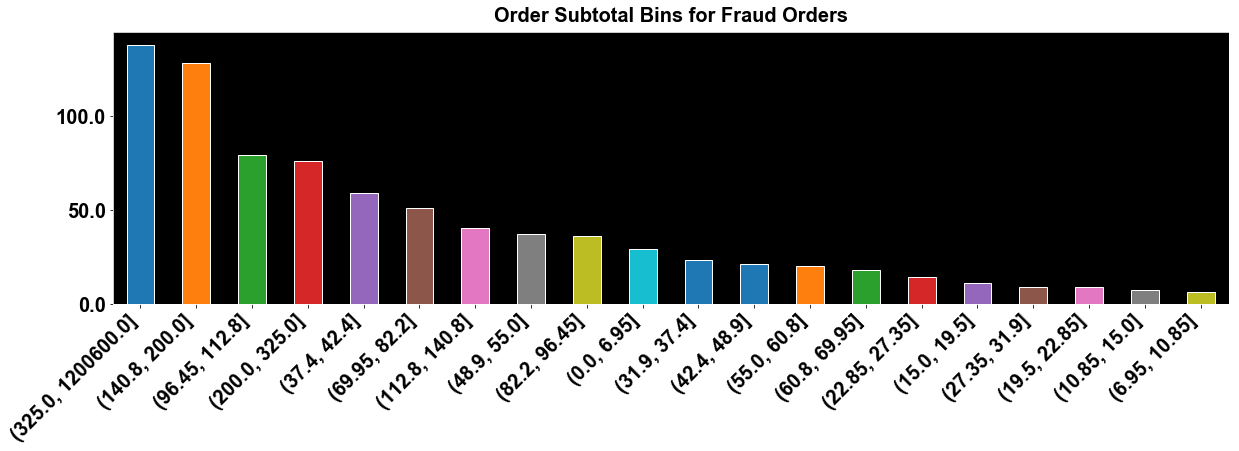

In [25]:
vc = orders_super_main[orders_super_main['fraud'] == 'yes']['order subtotal bins'].value_counts()

ax = vc.plot(kind = 'bar', edgecolor = 'white', figsize = (20,5))
ax.set_xticklabels(vc.index, fontsize = 20, rotation = 45, ha = 'right')
ax.set_yticklabels(ax.get_yticks(), fontsize = 20)
ax.set_title('Order Subtotal Bins for Fraud Orders', fontsize = 20, y = 1.02)
plt.show()

### Clean up postcodes
Take the first set of numbers before any dashes

In [26]:
for col in ['delivery','billing']:
    d = (orders_super_main[col + ' postcode'].str.split('-').str[0]).to_dict()
    orders_super_main[col + ' postcode'] = orders_super_main.index.map(d)

### Flag matching postcodes

In [27]:
orders_super_main['matching postcodes'] = np.where(orders_super_main['billing postcode'] == orders_super_main['delivery postcode'], 'yes', 'no')

In [28]:
v1 = orders_super_main['matching postcodes'].value_counts()
v2 = orders_super_main['matching postcodes'].value_counts().sum()
v3 = v1/v2
print('matching postcode proportions')
v3

matching postcode proportions


yes    0.856405
no     0.143595
Name: matching postcodes, dtype: float64

### Find US/non-US
If the billing country is US but the delivery country isn't, and vice versa

In [29]:
a = orders_super_main[(orders_super_main['billing country'] == 'united states')
                    | (orders_super_main['delivery country'] == 'united states')]
b = a[a['billing country'] != a['delivery country']]

orders_super_main['matching countries'] = np.where(orders_super_main['orders id'].isin(b['orders id'].tolist()),'yes','no')

### Find repeat customers

In [30]:
g1 = orders_super_main.groupby('customers email address')[['orders id']].count()
g1_email = g1[(g1['orders id'] > 1) & (g1.index != '')].index.tolist()

g2 = orders_super_main.groupby('customers id')[['orders id']].count()
g2_id = g2[(g2['orders id'] > 1) & (g2.index > 0)].index.tolist()

In [31]:
orders_super_main['repeat customer'] = np.where((orders_super_main['customers email address'].isin(g1_email))
                                              | (orders_super_main['customers id'].isin(g2_id)),
                                                'yes','no')

### Split off email domain

In [32]:
orders_super_main['email domain'] = orders_super_main['customers email address'].str.split('@', expand = True)[1]

In [33]:
vc = orders_super_main['email domain'].value_counts()
vc2 = pd.DataFrame(vc/vc.sum())
vc2.format_(['p1']).head(10)

,Email Domain
gmail.com,40.4%
yahoo.com,6.5%
hotmail.com,4.7%
comcast.net,1.6%
aol.com,1.1%
mac.com,0.8%
me.com,0.8%
msn.com,0.6%
verizon.net,0.6%
sbcglobal.net,0.5%


In [34]:
# top N most used email domains
n = 5
ls = vc.index[:n].tolist()

orders_super_main['email domain clean'] = np.where(orders_super_main['email domain'].isin(ls),
                                                   'common',
                                                   'not common')

### Map top parts by price

In [35]:
parts = pd.read_sql(
'''
SELECT
part_id,
products_price
FROM parts
''', db)

col_fix(parts)

In [36]:
q = 0.90
top_price = parts['products price'].quantile(q)

print('{:,.0f}% of prices are above or equal to ${:,.0f}'.format(q * 100, top_price))

ls = parts[parts['products price'] >= top_price]['part id'].tolist()

90% of prices are above or equal to $70


In [37]:
op = pd.read_sql(
'''
SELECT
orders_id,
part_id
FROM orders_products
''', db)

col_fix(op)

In [38]:
oids = list(set(op['orders id'][op['part id'].isin(ls)]))
orders_super_main['contains top part'] = np.where(orders_super_main['orders id'].isin(oids),'yes','no')

### Map whether the IP was flagged before

In [39]:
ip_flags = pd.read_sql(
'''
SELECT
*
FROM fraud_log
''', db)

col_fix(ip_flags)

orders_super_main['ip flagged before'] = np.where(orders_super_main['ip address'].isin(ip_flags['ip'].tolist()), 'yes', 'no')

### Clean up IP mismatch

In [40]:
d = {'1':'yes',
     '0':'no'}

orders_super_main['ip mismatch'] = [str(x) for x in orders_super_main['ip mismatch']]
for k,v in d.items():
    orders_super_main['ip mismatch'] = orders_super_main['ip mismatch'].str.replace(k,v)

### View nulls

In [41]:
n = orders_super_main[orders_super_main.isnull().any(1)]

v1 = len(n)
v2 = len(orders_super_main)

print('nulls account for {:,.1f}% of total lines\ndrop them for excel'.format(v1/v2*100))

nulls account for 0.4% of total lines
drop them for excel


# For Excel

### Prepare data for writing

In [42]:
min_oid = fraud_main['orders id'].min()
for_excel = orders_super_main[(orders_super_main['orders id'] >= min_oid)
                            & (orders_super_main['date purchased'].between(fraud_date_start, date_end))].copy()

d1 = str((for_excel['date purchased'].min()).date())
d2 = str((for_excel['date purchased'].max()).date())

print('excel data goes from {} to {}'.format(d1,d2))

excel data goes from 2018-05-01 to 2019-01-31


In [43]:
n = for_excel[for_excel.isnull().any(1)]

v1 = len(n)
v2 = len(for_excel)

print('nulls account for {:,.1f}% of total lines'.format(v1/v2*100))

if v1/v2 < 0.01:
    for_excel.dropna(inplace = True)
    for_excel.reset_index(drop = True, inplace = True)
    print('drop them for excel')
else:
    raise ValueError('check out ur nulls')
    
count = np.sum(n['fraud'] == 'yes')
print('\n{} nulls are fraud orders'.format(count))    

nulls account for 0.7% of total lines
drop them for excel

0 nulls are fraud orders


### Write to Excel for R script

In [44]:
if r_write == 'yes':
    
    title = 'Fraud Detection Data for R'
    writer = pd.ExcelWriter(csv_path + title + '.xlsx', engine = 'xlsxwriter')
    
    for_excel.to_excel(writer, 'data', index = False)
    
    writer.save()

In [45]:
for_excel['fraud'].value_counts()

no     214724
yes       398
Name: fraud, dtype: int64

# Rates of actual data

See [Confusion of the inverse](https://en.wikipedia.org/wiki/Confusion_of_the_inverse) for more.

* True Positive
* False Positive  


* True Negative
* False Negative

### Get data

In [209]:
osh_super_main = pd.read_sql(
'''
SELECT
osh.orders_status_history_id,
osh.date_added AS date_and_time_added,
DATE(osh.date_added) AS date_added,
DATE(o.date_purchased) AS date_purchased,
osh.orders_id,
o.order_total,
LOWER(os.orders_status_name) AS orders_status_name,
LOWER(o.payment_method) AS payment_method,
admin_comments
FROM orders_status_history osh
JOIN orders_status os ON osh.orders_status_id = os.orders_status_id
JOIN orders o ON osh.orders_id = o.orders_id
WHERE DATE(o.date_purchased) BETWEEN ' '''+ fraud_date_start +''' ' AND ' '''+ date_end +''' '
''', db)

col_fix(osh_super_main)

osh_super_main['date added'] = pd.to_datetime(osh_super_main['date added'])

### Restrict to OIDs that were sent to R

In [47]:
oids = for_excel['orders id'].tolist()

osh_super_main.drop(osh_super_main[~osh_super_main['orders id'].isin(oids)].index, inplace = True)
osh_super_main.reset_index(drop = True, inplace = True)

### Check it

In [48]:
v1 = len(for_excel)
v2 = len(set(osh_super_main['orders id']))

if v1 != v2:
    raise ValueError('totals do not match')

### Create rates

In [170]:
for_rates = osh_super_main.drop_duplicates(['orders id','orders status name']).copy()

t = len(set(for_rates['orders id']))
print('count of unique OIDs: {:,.0f}'.format(t))

count of unique OIDs: 215,122


### True Positive
We say fraud and it's fraud

In [107]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[for_rates['orders id'].isin(ls)]

b = a.groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
b.columns = b.columns.droplevel(0)

tp = int(b['fraud - void'].sum())

### False positive
We say fraud and it's not fraud

In [101]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[for_rates['orders id'].isin(ls)]

b = a.groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
b.columns = b.columns.droplevel(0)

fp = int(b['fraud - pending'].sum() - b['fraud - void'].sum())

### True Negative
We say not fraud and it's not fraud

In [137]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[~for_rates['orders id'].isin(ls)].groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
a.columns = a.columns.droplevel(0)

tn = int(len(a) - len(a[(a['fraud - confirmed'] == 1) | (a['fraud - void'] == 1)]))

### False negative
We say not fraud and it's fraud

In [143]:
ls = for_rates[for_rates['orders status name'] == 'fraud - pending']['orders id'].tolist()

a = for_rates[~for_rates['orders id'].isin(ls)].groupby(['orders id','orders status name'])[['orders id']].count().unstack(1)
a.columns = a.columns.droplevel(0)

fn = len(a[(a['fraud - confirmed'] == 1) | (a['fraud - void'] == 1)])

### Confusion Matrix
https://www.rdocumentation.org/packages/caret/versions/6.0-81/topics/confusionMatrix

In [144]:
cols = ['reference - no','reference - yes']
ix = ['prediction - no','prediction - yes']

data = [[tn,fn],[fp,tp]]

confusion_matrix = pd.DataFrame(columns = cols, index = ix, data = data)

if confusion_matrix.sum(1).sum() != t:
    raise ValueError('your confusion matrix does not sum to total')

### Make easier to read

In [176]:
confusion_matrix2 = confusion_matrix.copy()
confusion_matrix2.columns = ['really not fraud','really fraud']
confusion_matrix2.index = ['We Said Not Fraud','We Said Fraud']

fmt = ['n0','n0']
display(confusion_matrix2.format_(fmt))

,Really Not Fraud,Really Fraud
We Said Not Fraud,"212,902",183
We Said Fraud,"1,821",216


### See the proportions

In [146]:
fmt = ['p1','p1']
(confusion_matrix2/t).format_(fmt)

,Really Not Fraud,Really Fraud
We Said Not Fraud,99.0%,0.1%
We Said Fraud,0.8%,0.1%
